# LIBRARIES

In [3]:
import numpy  as np
import pandas as pd
import joblib as jb

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime


from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.metrics import mean_squared_log_error




import torch 
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import tensorflow as tf


import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

# DATA LOADING/CLEANING

In [4]:
df   = pd.read_csv('df.csv')
temp = pd.read_csv('temp.csv')

scaler_valores_g = jb.load('scaler_valores_g_09-11-21.pkl')
scaler_valores_e = jb.load('scaler_valores_e_09-11-21.pkl')

# MODELS FOR 1 TIME STEP FORWARD

In [5]:
def prep_seqs(dataset,conjunto,feature='valores_g',last=1,nex=1,ma=False,lstm=False):
    X , Y   = [],[]
    dx , dy = [],[]
    
    l = last
    n = nex-1
    
    base = -13
    train = dataset[:base][['valores_g','valores_e','vendas_g','vendas_e','prod_pe','prod_et','sin_ano','cos_ano','data']] 
    test  = dataset[base-(n+l):][['valores_g','valores_e','vendas_g','vendas_e','prod_pe','prod_et','sin_ano','cos_ano','data']] 
    
    if conjunto == 'train':
        df = train
    elif conjunto == 'test':
        df = test
        
    if lstm == True:
        for i in range(l,df.shape[0]-(n)):
            columns=['valores_g','valores_e','vendas_g','vendas_e','prod_pe','prod_et','sin_ano','cos_ano']
            columns.remove(feature)
            
            x      = df.iloc[i-l:i][columns]
            X.append(x)
            
            date_x = df.iloc[i-l:i]['data']
            dx.append(date_x)
              
            y     = df.iloc[i+n][feature]
            Y.append(y)
        
            date_y= df.iloc[i+n]['data']
            dy.append(date_y)

        Y = np.array(Y)
        Y = Y.astype(float)
       
        X = np.array(X)
        X = X.astype(float)
        X = np.swapaxes(X,1,2)
        X = np.swapaxes(X,0,2)
        X = np.swapaxes(X,1,2)
        
        return torch.from_numpy(X).float(),torch.from_numpy(Y).float(),dx,dy
    
    elif ma == True:
        for i in range(l,df.shape[0]-(n)):
            x      = df.iloc[i-l:i][feature]
            X.append(x)
            
            date_x = df.iloc[i-l:i]['data']
            dx.append(date_x)
            
            
            y     = df.iloc[i+n][feature]
            Y.append(y)
        
            date_y= df.iloc[i+n]['data']
            dy.append(date_y)
         
        
        Y = np.array(Y)
        Y = Y.astype(float)
        
        
        X = np.array(X)
        X = X.astype(float)
        
        return X,Y,dx,dy
        
       

In [32]:
def moving_average(df,feature,n=2,colors='p1'):

    
    if colors == 'p1':
        crs = ['steelblue','#2ca02c','#ff7f0e']
    elif colors=='p2':
        crs = ['grey','green','red']
       
    df = df.reset_index()
    
    if feature == 'Gasolina':
        target = 'valores_g'
        
    elif feature == 'Etanol':
        target = 'valores_e'
    
        
    Xval,Yval,dxval,dyval = prep_seqs(df,'test',target,last = n,nex=1,ma=True)    
    
    res  = pd.DataFrame()
    res['valores']  = list(Yval) 
    
    lista = list()
    
    for f in range(len(Xval)):
        shift_1 = list(Xval[f])[1]
        shift_2 = list(Xval[f])[0]
        
        
        avg = ((shift_1+shift_2)/2)
        lista.append(avg)
        
    res[f'{n}M_MA'] = lista

    vals  = res['valores'].values
    preds = res[f'{n}M_MA'].values
    datas = dyval
    interv_val = [dyval[0],dyval[-1]]
    
    mape = round(mean_absolute_percentage_error(vals,preds)*100,4)
    mae  = round(mean_absolute_error(vals,preds),4)

    plt.figure(figsize = (20,8))
    plt.title('MA dos Últimos 2 Meses x Valores Reais',fontsize=17)
    
    plt.plot(datas,vals,marker='o',color=crs[0],label='Valores Reais') 
    plt.plot(datas,preds,marker='o',color=crs[2],label='MA (2 Meses)')
    plt.errorbar(datas,preds,yerr=mae,fmt='X',label=f'|Erro| = R${mae}',color=crs[2])
    
    plt.legend(fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    
    
    return mape,mae,interv_val,preds,vals

# MOVING AVERAGE

In [33]:
resultados_gasolina = pd.DataFrame()
resultados_etanol   = pd.DataFrame()
MAPE, MAE, STD = list(),list(),list()

### MA FOR GASOLINE

Intervalo de Validação 2020-09-01 - 2021-09-01


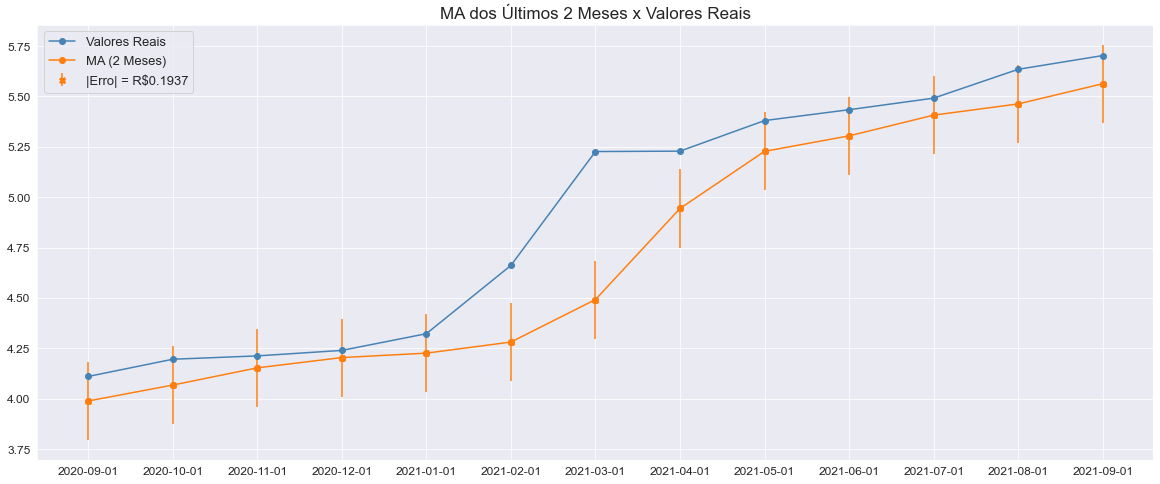

In [34]:
mape,mae,interv_val,preds_g,vals_g = moving_average(df,'Gasolina',n=2)
MAPE.append(mape)
MAE.append(mae)
print(f'Intervalo de Validação {interv_val[0]} - {interv_val[1]}')

### MA FOR ETHANOL

Intervalo de Validação 2020-09-01 - 2021-09-01


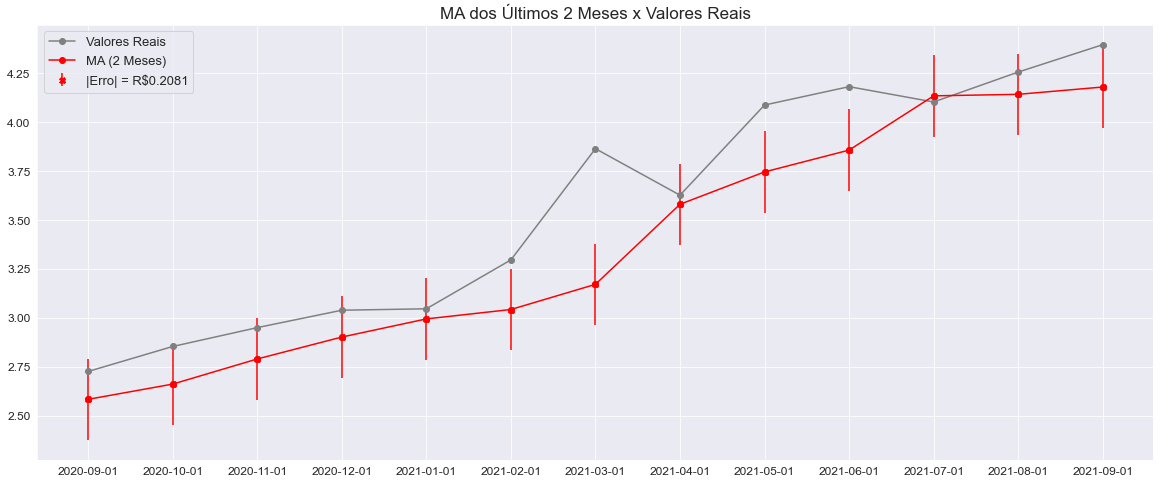

In [35]:
mape,mae,interv_val,preds,vals = moving_average(df,'Etanol',colors='p2')
MAPE.append(mape)
MAE.append(mae)
print(f'Intervalo de Validação {interv_val[0]} - {interv_val[1]}')

In [36]:
print(f'p/Gasolina MAPE {MAPE[0]} / MAE {MAE[0]}')
print(f'p/Etanol   MAPE {MAPE[1]} / MAE {MAE[1]}')

p/Gasolina MAPE 3.8767 / MAE 0.1937
p/Etanol   MAPE 5.7705 / MAE 0.2081


# LSTM

In [37]:
def fit_lstm(temp,feature,n_last=2,n_next=1,iterations=63,neurons=256,n_layers=3):
    print(f'Modelo de Previsão p/ {feature}')
    errors = list()
    
    if feature == 'Gasolina':
        target = 'valores_g'
    elif feature == 'Etanol':
        target = 'valores_e'
    
    df = temp.reset_index()
    Xtrain,Ytrain,dx,dy   = prep_seqs(df,'train',target ,last  = n_last, nex = n_next,lstm =True)
    
    seed = 0 
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    lstm = LSTMRNN(neurons,n_layers)
    print(lstm)
    criterion = nn.L1Loss()
    lstm_optimizer = optim.Adam(lstm.parameters())
    
    for k in range(iterations):
        lstm.zero_grad()
    
        o = lstm(Xtrain)
    
        loss = criterion(o,Ytrain)
        error = mean_absolute_percentage_error(o.detach().numpy(),Ytrain.detach().numpy())
        errors.append(error)
           
        loss.backward()
        lstm_optimizer.step()
        
    history = o
    errors = np.array(errors)
    
    plt.figure(figsize=(5,3))
    plt.title('Residual History')
    plt.plot(errors[2:]) 
    return lstm,history

In [38]:
def fit_lstm(temp,scalers,feature='Gasolina',n_last=2,n_next=1,iterations=63,neurons=256,n_layers=3):
    
    
    loss_train = list()
    loss_val   = list()
    iteration  = list()
    
    if feature == 'Gasolina':
        target = 'valores_g'
        scaler = scalers[0]
    elif feature == 'Etanol':
        target = 'valores_e'
        scaler = scalers[1]
    
    df = temp.reset_index()
    
    Xtrain,Ytrain,dx,dy   = prep_seqs(df,'train',target,last  = n_last, nex = n_next,lstm =True)
    Xval,Yval,dxval,dyval = prep_seqs(df,'test' ,target,last  = n_last, nex = n_next,lstm  =True)
    
    seed = 0 
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    lstm = LSTMRNN(neurons,n_layers)
    criterion = nn.L1Loss()
    lstm_optimizer = optim.Adam(lstm.parameters())
    print(lstm)
    
    min_error = 100
    for k in range(iterations):
        lstm.zero_grad()
    
        o = lstm(Xtrain)
        p = lstm(Xval)
        
        loss = criterion(o,Ytrain)
        loss_train.append(loss.detach())
        
        
        loss_v = criterion(p,Yval)
        loss_val.append(loss_v.detach())
        
        loss.backward()
        lstm_optimizer.step()
        
        p = p.detach()
        p = p.numpy().squeeze().reshape(-1,1)
        p = scaler.inverse_transform(p)
        p = np.exp(p)

        n_Yval = Yval.reshape(-1,1)
        n_Yval = scaler.inverse_transform(n_Yval)
        n_Yval = np.exp(n_Yval)   
    
        preds = np.array(list(p))
        vals  = np.array(list(n_Yval))
        datas = np.array(list(dyval))
        interv_val = [datas[0],datas[-1]]
    
        
        mape = round(mean_absolute_percentage_error(vals,preds)*100,4)
        mae  = round(mean_absolute_error(vals,preds),4)

        iteration.append(k)
        

    print(f'MAPE:{mape}')
    print(f'MAE:{mae}')
    
    plt.figure(figsize = (20,8))
    plt.title(f'LSTM x Valores Reais \n {feature}',fontsize=17)
    
    plt.plot(datas,vals,marker='o',color='black',label='Valores Reais') 
    plt.plot(datas,preds,color='orange',label=f'LSTM ({n_next} Mês)')
    plt.errorbar(datas,preds,yerr=mae,fmt='X',label=f'|Erro| = R${mae}',color='orange')
    
    plt.legend(fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)    
     
    return vals,datas,preds,mape,mae

### LSTM FOR GASOLINE

LSTMRNN(
  (lstm): LSTM(7, 256, num_layers=6)
  (drop): Dropout(p=0.2, inplace=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)
MAPE:2.8625
MAE:0.146
Intervalo de Validação 2020-09-01 - 2021-09-01


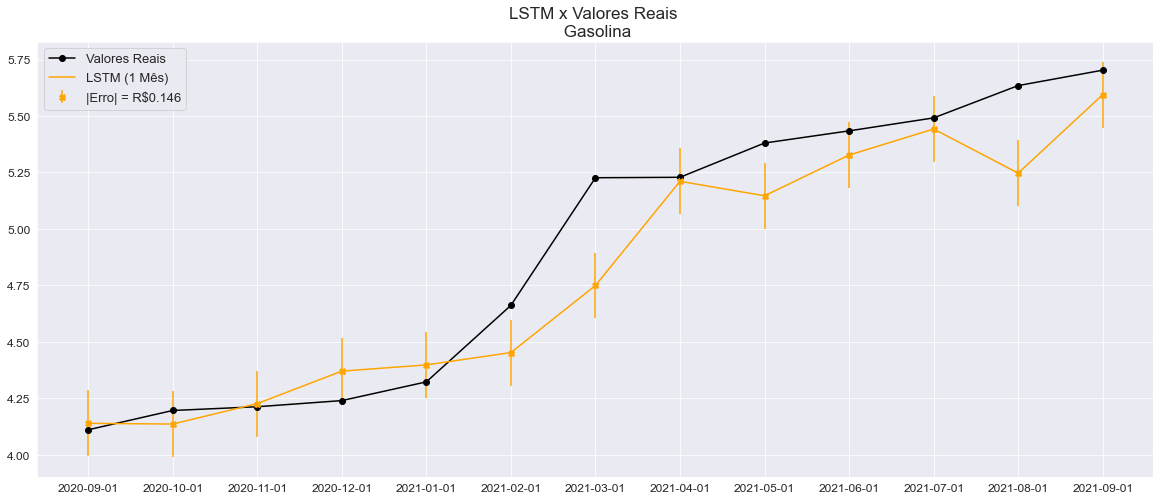

In [39]:
#[1, 288, 256, 6] --> 2.86 (NP)(DROP = 0.2)
parameters = [1, 288, 256, 6]
n_last = parameters[0]
it     = parameters[1]
nrs    = parameters[2]
n_layers = parameters[3]

class LSTMRNN(nn.Module):
        def __init__(self,hidden_size,n_layers):
            super(LSTMRNN,self).__init__()
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(7,self.hidden_size,num_layers=n_layers)
            self.drop = nn.Dropout(p=0.2,inplace=True)
            self.out = nn.Linear(self.hidden_size,1)
        
        def forward(self,input):
            output , h = self.lstm(input)
            output = output[-1 , : ]
            output = self.drop(output)
            output = self.out(output)
       
            return output.squeeze()
n_next = 1
scalers = [scaler_valores_g,scaler_valores_e]

n_vals,n_datas,n_preds,mape,mae = fit_lstm(temp,scalers,'Gasolina',n_last=n_last,
                                                                     n_next=n_next,iterations=it,neurons=nrs,
                                                                     n_layers=n_layers)
MAPE.append(mape)
MAE.append(mae)
print(f'Intervalo de Validação {interv_val[0]} - {interv_val[1]}')

### LSTM FOR ETHANOL

LSTMRNN(
  (lstm): LSTM(7, 250, num_layers=6)
  (drop): Dropout(p=0.25, inplace=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)
MAPE:4.7686
MAE:0.183
Intervalo de Validação 2020-09-01 - 2021-09-01


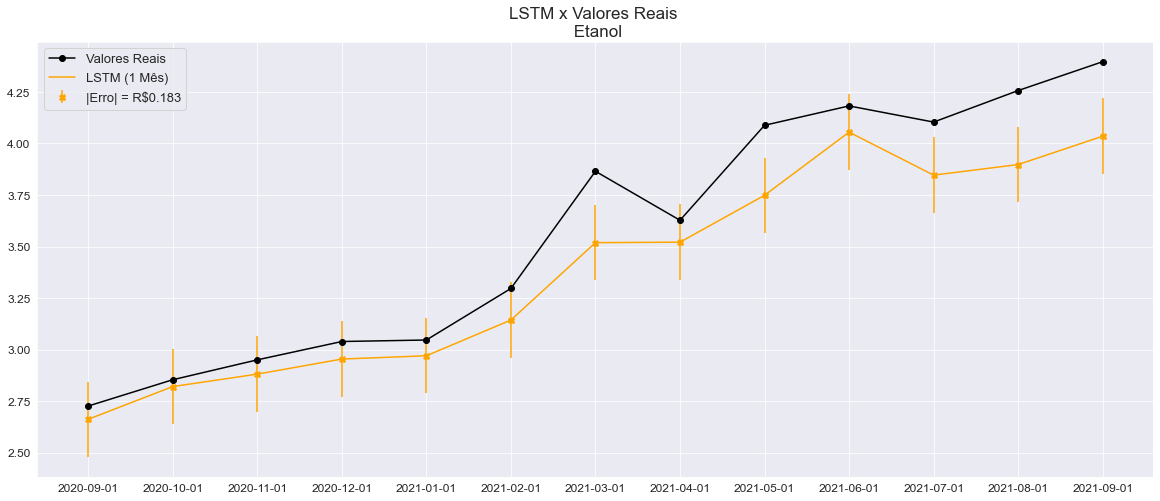

In [40]:
#[1,352,250,6] --> 4.76 (NP)(DROP = 0.25)
parameters = [1,352,250,6]
n_last = parameters[0]
it     = parameters[1]
nrs    = parameters[2]
n_layers = parameters[3]

class LSTMRNN(nn.Module):
        def __init__(self,hidden_size,n_layers):
            super(LSTMRNN,self).__init__()
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(7,self.hidden_size,num_layers=n_layers)
            self.drop = nn.Dropout(p=0.25,inplace=True)
            self.out = nn.Linear(self.hidden_size,1)
        
        def forward(self,input):
            output , h = self.lstm(input)
            output = output[-1 , : ]
            output = self.drop(output)
            output = self.out(output)
       
            return output.squeeze()
n_next = 1
scalers = [scaler_valores_g,scaler_valores_e]

n_vals,n_datas,n_preds,mape,mae = fit_lstm(temp,scalers,'Etanol',n_last=n_last,n_next=n_next,iterations=it,
                                                                     neurons=nrs,n_layers=n_layers)
MAPE.append(mape)
MAE.append(mae)
print(f'Intervalo de Validação {interv_val[0]} - {interv_val[1]}')

In [41]:
print(f'p/Gasolina MAPE {MAPE[2]} / MAE {MAE[2]}')
print(f'p/Etanol   MAPE {MAPE[3]} / MAE {MAE[3]}')

p/Gasolina MAPE 2.8625 / MAE 0.146
p/Etanol   MAPE 4.7686 / MAE 0.183


# EVALUATION

In [42]:
def addlabels(groups):
    for i in groups:
        h = i.get_height()
        plt.annotate('{}'.format(h),
                     xy = (i.get_x()+i.get_width()/2,h),
                     xytext = (0,4),
                     textcoords = 'offset points',
                     ha='center',fontsize=13) 

In [43]:
resultados= pd.DataFrame()

resultados['Combustivel'] = ['Gasolina','Etanol']
resultados['MAPE_ma']   = [MAPE[0],MAPE[1]]
resultados['MAPE_lstm'] = [MAPE[2],MAPE[3]]
resultados['MAE_ma']    = [MAE[0],MAE[1]]
resultados['MAE_lstm']  = [MAE[2],MAE[3]]

In [44]:
resultados

,Combustivel,MAPE_ma,MAPE_lstm,MAE_ma,MAE_lstm
0,Gasolina,3.8767,2.8625,0.1937,0.146
1,Etanol,5.7705,4.7686,0.2081,0.183


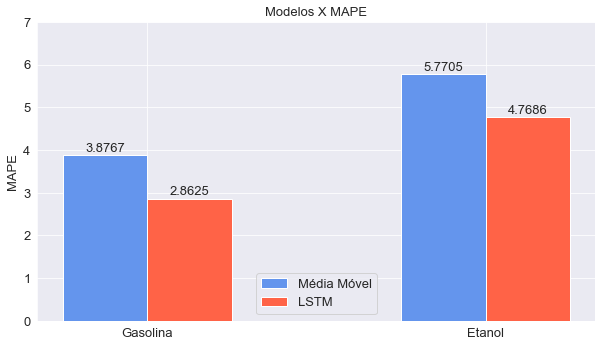

In [45]:
plt.figure(figsize=(10,5.5))
l = 0.25
x = list(resultados['Combustivel'])
bar1 = np.arange(len(x))
g1 = plt.bar(bar1 - l/2,resultados['MAPE_ma'],l,label='Média Móvel',color='cornflowerblue')
g2 = plt.bar(bar1 + l/2,resultados['MAPE_lstm'],l,label='LSTM',color='tomato')
addlabels(g1)
addlabels(g2)
plt.title('Modelos X MAPE',fontsize=13)
plt.ylabel('MAPE',fontsize=13)
plt.yticks(np.arange(0,8,1),fontsize=13)
plt.xticks(bar1,x)
plt.xticks(bar1,x,fontsize=13)
plt.legend(loc='lower center',fontsize=13)
plt.show()

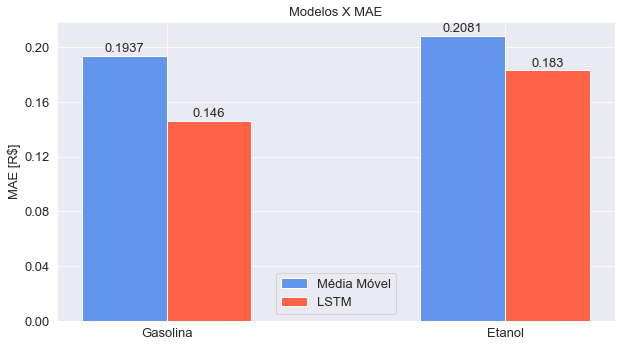

In [46]:
plt.figure(figsize=(10,5.5))
l = 0.25
x = list(resultados['Combustivel'])
bar1 = np.arange(len(x))

g1 = plt.bar(bar1 - l/2,resultados['MAE_ma'],l,label='Média Móvel',color='cornflowerblue')
g2 = plt.bar(bar1 + l/2,resultados['MAE_lstm'],l,label='LSTM',color='tomato')
addlabels(g1)
addlabels(g2)
plt.title('Modelos X MAE',fontsize=13)
plt.ylabel('MAE [R$]',fontsize=13)
plt.yticks(np.arange(0,0.21,0.04),fontsize=13)
plt.xticks(np.arange(0,1,1))
plt.xticks(bar1,x,fontsize=13)
plt.legend(loc='lower center',fontsize=13)
plt.show()

# MULTI-STEPS MODELS

### MOVING AVERAGE

In [21]:
def multi_moving_average(df,feature,n=2): 
    preds = list()
     
        
    
    df = df.reset_index()
    
    if feature == 'Gasolina':
        target = 'valores_g'
        crs = ['steelblue','#2ca02c','#ff7f0e']
        
    elif feature == 'Etanol':
        target = 'valores_e'
        crs = ['grey','green','red']
        
    n_nex = 3
    n_last =2 
    Xval,Yval,dxval,dyval = prep_seqs(df,'test' ,target ,last = n_last, nex = n_nex,ma  =True)    
  
    k = 0

    
    for i in range(len(Xval)):
        v0 = list(Xval[i])[0] 
        v1 = list(Xval[i])[1]
        
        p1 = (v0+v1)/2
        p2 = (v1+p1)/2
        p3 = (p1+p2)/2
        preds.append(p3)
   
    vals  = list(Yval)
    datas = list(dyval)
    interv_val = [datas[0],datas[-1]]
    
    mape = round(mean_absolute_percentage_error(Yval,preds)*100,2)   
    mae = round(mean_absolute_error(Yval,preds),2)
    
    print(f'Intervalor de Validação {dyval[0]} : {dyval[-1]}') 
    print(f'MAPE: {mape}')
    
    plt.figure(figsize = (20,8))
    plt.title('MA dos Últimos 2 Meses x Valores Reais',fontsize=17)
    
    plt.plot(datas,vals,marker='o',color=crs[0],label='Valores Reais') 
    plt.plot(datas,preds,marker='o',color=crs[2],label='MA (2 Meses)')
    plt.errorbar(datas,preds,yerr=mae,fmt='X',label=f'|Erro| = R${mae}',color=crs[2])
   
    plt.legend(fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
   
   
    
    
    return mape,mae
       

In [22]:
MAPE,MAE = list(),list()

### MA FOR GASOLINE

Intervalor de Validação 2020-09-01 : 2021-09-01
MAPE: 8.75


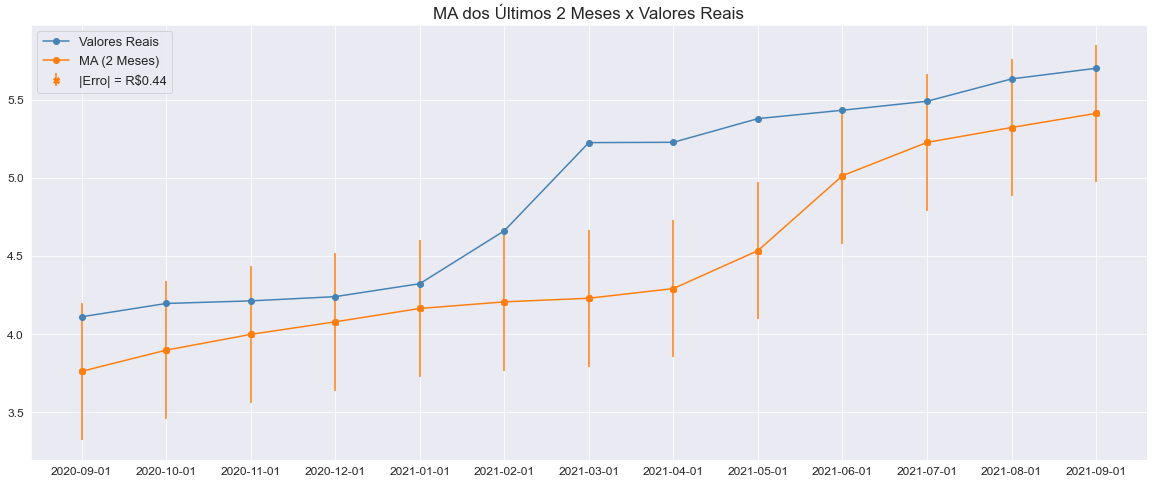

In [23]:
mape,mae= multi_moving_average(df,'Gasolina')
MAPE.append(mape)
MAE.append(mae)

### MA FOR ETHANOL

Intervalor de Validação 2020-09-01 : 2021-09-01
MAPE: 12.43


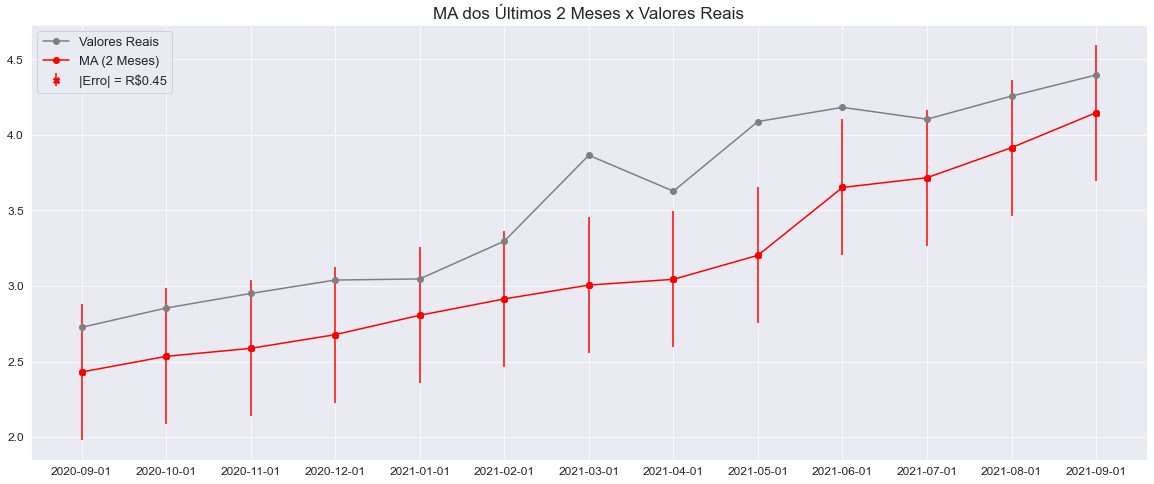

In [24]:
mape,mae= multi_moving_average(df,'Etanol')
MAPE.append(mape)
MAE.append(mae)

In [25]:
print(f'p/Gasolina MAPE {MAPE[0]} / MAE {MAE[0]}')
print(f'p/Etanol   MAPE {MAPE[1]} / MAE {MAE[1]}')

p/Gasolina MAPE 8.75 / MAE 0.44
p/Etanol   MAPE 12.43 / MAE 0.45


## LSTM

### LSTM FOR GASOLINE

LSTMRNN(
  (lstm): LSTM(7, 150, num_layers=5)
  (drop): Dropout(p=0.15, inplace=True)
  (out): Linear(in_features=150, out_features=1, bias=True)
)
MAPE:4.2286
MAE:0.2171
Intervalo de Validação 2020-09-01 - 2021-09-01


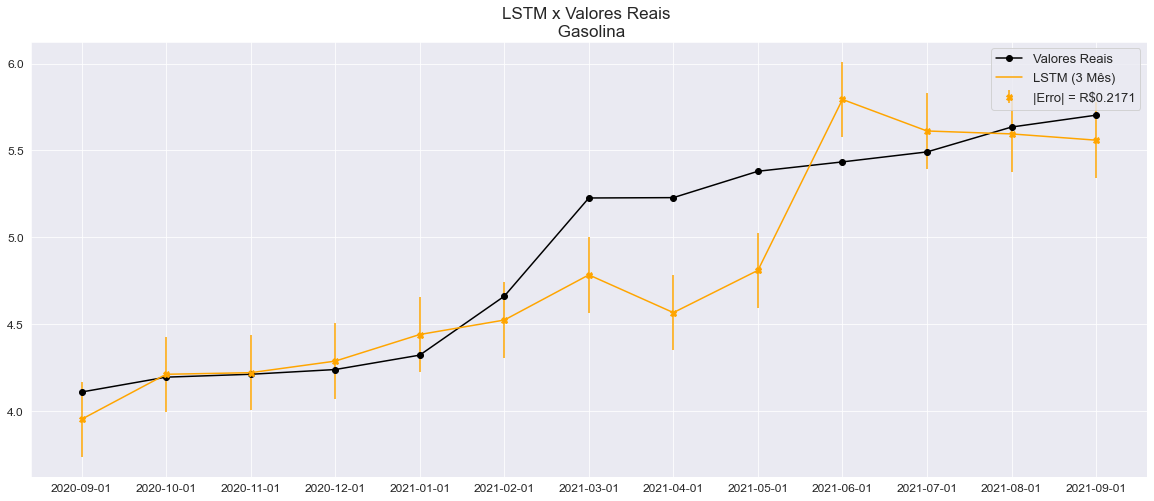

In [26]:
#[1, 304, 150, 5] --> 4.22 (P)(DROP = 0.15)
parameters = [1, 304, 150, 5]
n_last = parameters[0]
it     = parameters[1]
nrs    = parameters[2]
n_layers = parameters[3]

class LSTMRNN(nn.Module):
        def __init__(self,hidden_size,n_layers):
            super(LSTMRNN,self).__init__()
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(7,self.hidden_size,num_layers=n_layers)
            self.drop = nn.Dropout(p=0.15,inplace=True)
            self.out = nn.Linear(self.hidden_size,1)
        
        def forward(self,input):
            output , h = self.lstm(input)
            output = output[-1 , : ]
            output = self.drop(output)
            output = self.out(output)
       
            return output.squeeze()
n_next = 3
scalers = [scaler_valores_g,scaler_valores_e]

n_vals,n_datas,n_preds,mape,mae = fit_lstm(temp,scalers,'Gasolina',n_last=n_last,n_next=n_next,iterations=it,
                                                                     neurons=nrs,n_layers=n_layers)
MAPE.append(mape)
MAE.append(mae)
print(f'Intervalo de Validação {interv_val[0]} - {interv_val[1]}')


### LSTM FOR ETHANOL

LSTMRNN(
  (lstm): LSTM(7, 250, num_layers=3)
  (drop): Dropout(p=0.25, inplace=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)
MAPE:12.9065
MAE:0.501
Intervalo de Validação 2020-09-01 - 2021-09-01


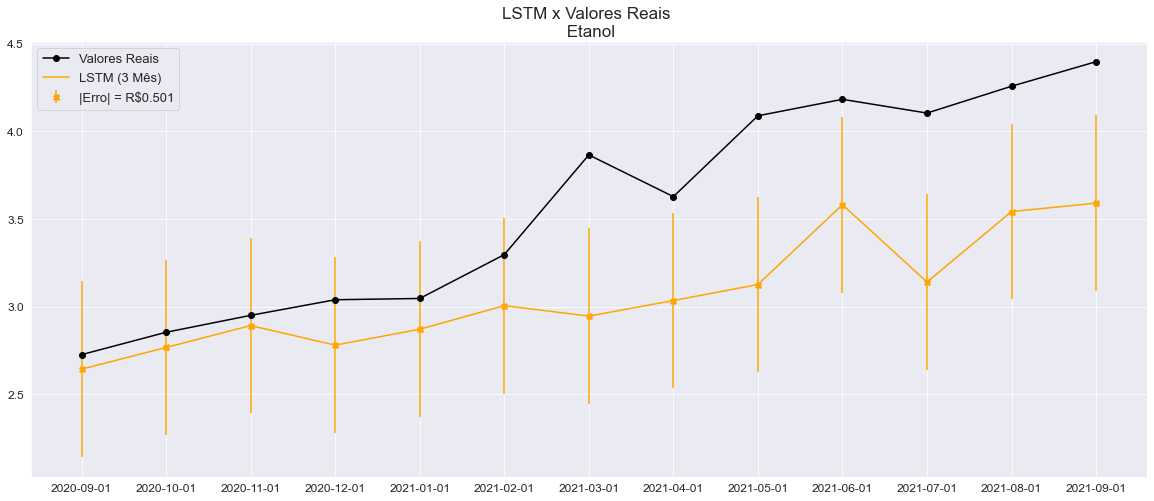

In [27]:
#[1,124,250,3] --> 12.89 (P))(DROP = 0.25)
parameters = [1,124,250,3]
n_last = parameters[0]
it     = parameters[1]
nrs    = parameters[2]
n_layers = parameters[3]

class LSTMRNN(nn.Module):
        def __init__(self,hidden_size,n_layers):
            super(LSTMRNN,self).__init__()
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(7,self.hidden_size,num_layers=n_layers)
            self.drop = nn.Dropout(p=0.25,inplace=True)
            self.out = nn.Linear(self.hidden_size,1)
        
        def forward(self,input):
            output , h = self.lstm(input)
            output = output[-1 , : ]
            output = self.drop(output)
            output = self.out(output)
       
            return output.squeeze()
n_next = 3
scalers = [scaler_valores_g,scaler_valores_e]

n_vals,n_datas,n_preds,mape,mae = fit_lstm(temp,scalers,'Etanol',n_last=n_last,n_next=n_next,iterations=it,
                                                                     neurons=nrs,n_layers=n_layers)
MAPE.append(mape)
MAE.append(mae)
print(f'Intervalo de Validação {interv_val[0]} - {interv_val[1]}')

In [28]:
print(f'p/Gasolina MAPE {MAPE[2]} / MAE {MAE[2]}')
print(f'p/Etanol   MAPE {MAPE[3]} / MAE {MAE[3]}')

p/Gasolina MAPE 4.2286 / MAE 0.2171
p/Etanol   MAPE 12.9065 / MAE 0.501


# EVALUATION

In [29]:
resultados= pd.DataFrame()

resultados['Combustivel'] = ['Gasolina','Etanol']
resultados['MAPE_ma']   = [MAPE[0],MAPE[1]]
resultados['MAPE_lstm'] = [MAPE[2],MAPE[3]]
resultados['MAE_ma']    = [MAE[0],MAE[1]]
resultados['MAE_lstm']  = [MAE[2],MAE[3]]

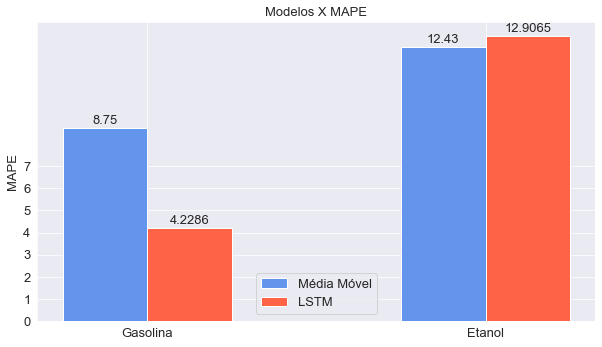

In [30]:
plt.figure(figsize=(10,5.5))
l = 0.25
x = list(resultados['Combustivel'])
bar1 = np.arange(len(x))
g1 = plt.bar(bar1 - l/2,resultados['MAPE_ma'],l,label='Média Móvel',color='cornflowerblue')
g2 = plt.bar(bar1 + l/2,resultados['MAPE_lstm'],l,label='LSTM',color='tomato')
addlabels(g1)
addlabels(g2)
plt.title('Modelos X MAPE',fontsize=13)
plt.ylabel('MAPE',fontsize=13)
plt.yticks(np.arange(0,8,1),fontsize=13)
plt.xticks(bar1,x)
plt.xticks(bar1,x,fontsize=13)
plt.legend(loc='lower center',fontsize=13)
plt.show()

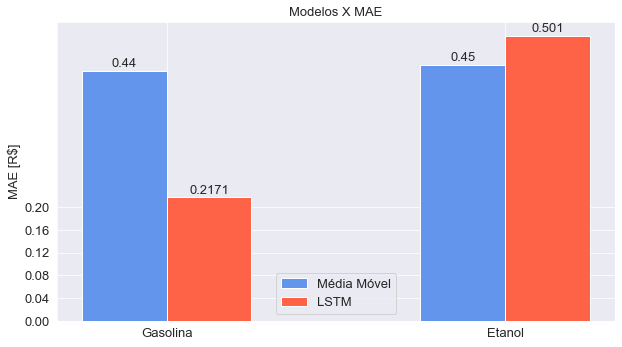

In [31]:
plt.figure(figsize=(10,5.5))
l = 0.25
x = list(resultados['Combustivel'])
bar1 = np.arange(len(x))

g1 = plt.bar(bar1 - l/2,resultados['MAE_ma'],l,label='Média Móvel',color='cornflowerblue')
g2 = plt.bar(bar1 + l/2,resultados['MAE_lstm'],l,label='LSTM',color='tomato')
addlabels(g1)
addlabels(g2)
plt.title('Modelos X MAE',fontsize=13)
plt.ylabel('MAE [R$]',fontsize=13)
plt.yticks(np.arange(0,0.21,0.04),fontsize=13)
plt.xticks(np.arange(0,1,1))
plt.xticks(bar1,x,fontsize=13)
plt.legend(loc='lower center',fontsize=13)
plt.show()